# Brain Disorder Diagnosis

:::{figure} images/flowchart.png
Machine learning pipeline to predict ASD vs control subjects.
:::

In this tutorial, we will use `PyKale` [1] to train models that classify individuals with Autism Spectrum Disorder (ASD) and healthy controls based on two data modalities: functional magnetic resonance imaging (fMRI) and phenotypic features.

We will work with preprocessed data from the [Autism Brain Imaging Data Exchange (ABIDE)](https://fcon_1000.projects.nitrc.org/indi/abide/) [2], which includes fMRI and phenotypic information for over 1,000 subjects, contributed by 17 research centers worldwide.

The multimodal approach used in this tutorial involves **regularization**, where phenotypic features are incorporated into the regularization term to reduce the phenotypic effect (e.g., site effects) in the imaging feature embedding and improve cross-site classification performance.

The main tasks of the tutorial are as follows:

- Load fMRI and phenotypic data
- Train and evaluate AI models for ASD classification using both data modalities
  - Explore different cross-validation strategies: random stratified k-fold vs. leave-one-site-out
  - Apply the method from the TMI paper [Kunda et al. (2022)](https://ieeexplore.ieee.org/abstract/document/9874890/) [3], which improves classification performance by reducing data heterogeneity through incorporating phenotypic data into the regularisation of imaging feature embeddings
- Visualize the highly weighted features based on model weights for interpretation


<!-- :::{figure} images/abide.png
Autism Brain Imaging Data Exchange
::: -->

## Step 0: Environment Preparation

**GPU is not required** for this tutorial, you can run the following code cells without changing the runtime type. 

To get started, we will install the necessary packages and load a set of helper functions to support the tutorial workflow. Run the cell below to copy all tutorial-related materials to your Google Colab runtime directory. To keep the output clean and focused on interpretation, we will also suppress warnings.

In [ ]:
import os
import site
import sys
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

if "google.colab" in str(get_ipython()):
    sys.path.insert(0, site.getusersitepackages())
    !git clone --single-branch -b main https://github.com/pykale/mmai-tutorials
    %cp -r /content/mmai-tutorials/tutorials/brain-disorder-diagnosis/* /content/
    %rm -r /content/mmai-tutorials

:::{admonition} Optional
:class: tip
Learn more about the [helper functions](https://pykale.github.io/mmai-tutorials/tutorials/brain-disorder-diagnosis/extend-reading/helper-functions.html) used in this tutorial.
:::

### Install Required Packages

Run the cell below to install the required packages for this tutorial. ***Estimated Runtime in Google Colab***: 3-5 minutes

The details for main packages required (excluding `PyKale`) for this tutorial are:

- **gdown**: A utility package that simplifies downloading files and folders directly from Google Drive.

- **nilearn**: A Python library for neuroimaging analysis. It offers convenient tools for processing, analysing, and visualizing functional MRI (fMRI) data.

- **yacs**: A lightweight configuration management library used to store and organize experiment settings in a hierarchical and human-readable format.

In [ ]:
%%capture
!pip install --quiet \
    "pykale[example]@git+https://github.com/pykale/pykale@main" \
    gdown==5.2.0 torch-geometric==2.6.0 torch_sparse torch_scatter \
    -f https://data.pyg.org/whl/torch-2.6.0+cpu.html

### Configuration

Please refer to the [configuration tutorial](https://pykale.github.io/mmai-tutorials/tutorials/setup-config/tutorial-0.html#step-2-configuration-using-yml-files) for general configuration setup instructions for this workshop.

In this tutorial, [`configs/lpgo/base.yml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/brain-disorder-diagnosis/configs/lpgo/base.yml) provides a lightweight setup suitable for quick experimentation. **Note** that this configuration file is used to describe the outputs shown in this notebook.

Therefore, if a different configuration is used during execution, some of the descriptions or assumptions in the notebook may no longer apply and should be interpreted with caution, as they may become misleading.

:::{note}
The `base.yml` configuration is designed to yield acceptable performance within 15–25 minutes using a free Google Colab runtime. However, the expected performance will be lower compared to the results reported in Kunda et al. (2022).

For more extensive experimentation, the default hyperparameter grid in `config.py` provides a broader search space, which may yield improved results at the cost of increased runtime.

If you wish to replicate the exact settings used in [Kunda et al. (2022)](https://ieeexplore.ieee.org/abstract/document/9874890/), the [`configs/lpgo/tmi2022.yml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/brain-disorder-diagnosis/configs/lpgo/tmi2022.yml) and [`configs/skf/tmi2022.yml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/brain-disorder-diagnosis/configs/skf/tmi2022.yml) files includes the hyperparameter grid taken directly from their [original source code](https://github.com/kundaMwiza/fMRI-site-adaptation).
:::

A detailed description of each configurable option is provided as optional extended reading in the following sections.

In [ ]:
from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("configs/lpgo/base.yml")

# A subset of the configuration can be modified here for quick playtest.
# Uncomment the following lines if you are interested in quickly
# modifying the configuration without modifying or making new `yml` files.

# cfg.DATASET.ATLAS = "hcp-ica"
# cfg.DATASET.FC = "tangent-pearson"
# cfg.DATASET.TOP_K_SITES = 5
# cfg.CROSS_VALIDATION.SPLIT = "skf"
# cfg.CROSS_VALIDATION.NUM_FOLDS = 5
# cfg.CROSS_VALIDATION.NUM_REPEATS = 2
# cfg.MODEL.CLASSIFIER = "lr"
# cfg.MODEL.PARAM_GRID = None
# cfg.MODEL.NUM_SEARCH_ITER = 100
# cfg.MODEL.NUM_SOLVER_ITER = 100

print(cfg)

CROSS_VALIDATION:
  NUM_FOLDS: 1
  NUM_REPEATS: 5
  SPLIT: lpgo
DATASET:
  ATLAS: hcp-ica
  DATA_DIR: data
  FC: tangent-pearson
  TOP_K_SITES: 10
PHENOTYPE:
  STANDARDIZE: site
RANDOM_STATE: 0
TRAINER:
  CLASSIFIER: lr
  NONLINEAR: False
  NUM_SEARCH_ITER: 100
  NUM_SOLVER_ITER: 100
  N_JOBS: -2
  PARAM_GRID: None
  PRE_DISPATCH: 2*n_jobs
  REFIT: accuracy
  SCORING: ['accuracy', 'roc_auc']
  SEARCH_STRATEGY: random
  VERBOSE: 0


## Step 1: Data Loading and Preparation

Typically, raw fMRI scans require extensive preprocessing before they can be used in a machine learning pipeline. However, the **ABIDE** dataset provides several preprocessed derivatives, which can be downloaded directly from the [Preprocessed Connectomes Project (PCP)](https://preprocessed-connectomes-project.org/abide/), eliminating the need for manual preprocessing.

:::{attention}
Given the long runtime required to compute functional connectivity (FC) embeddings from raw fMRI data, this notebook omits that step and instead provides **pre-computed embeddings** via the `load_data` function, along with the associated atlas.

For users interested in computing the ROI time series and FC embeddings from scratch, assuming preprocessed images are available, we recommend referring to the following tools and functions:

- [`NiftiLabelsMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html): For use with **deterministic (3D)** atlases.
- [`NiftiMapsMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMapsMasker.html): For use with **probabilistic (4D)** atlases.
- `extract_functional_connectivity` function in `preprocess.py`: This function wraps `nilearn.connectome.ConnectivityMeasure` and supports composing multiple FC measures. For example, to compute a **Tangent-Pearson** embedding from a list of ROI time series, you can call:
  ```python
  extract_functional_connectivity(time_series, ["tangent", "pearson"])
  ```
:::

### Data Loading

As mentioned earlier, we provide a `load_data` function to load **pre-computed functional connectivity (FC)** embeddings along with associated phenotypic information.  
This function supports automated downloading via [gdown](https://pypi.org/project/gdown/) by reading from manifest files if the data is not found locally.

:::{admonition} Extended Reading (optional)
:class: tip
Learn more about the [configuration arguments for data loading](https://pykale.github.io/mmai-tutorials/tutorials/brain-disorder-diagnosis/extend-reading/data-config.html#configuration-arguments-for-data-loading).
:::

In [ ]:
from helpers.data import load_data

# A subset of the configuration can be modified here for quick playtest.
# Uncomment the following lines if you are interested in quickly
# modifying the configuration without modifying or making new `yml` files.

# cfg.DATASET.ATLAS = "hcp-ica"
# cfg.DATASET.FC = "tangent-pearson"
# cfg.DATASET.TOP_K_SITES = 5

fc, phenotypes, rois, coords = load_data(
    cfg.DATASET.DATA_DIR,
    cfg.DATASET.ATLAS,
    cfg.DATASET.FC,
    top_k_sites=cfg.DATASET.TOP_K_SITES,
)

✔ File found: data/abide/fc/hcp-ica/tangent-pearson.npy
✔ File found: data/abide/phenotypes.csv
✔ Atlas folder found: data/atlas/deterministic/hcp-ica


The downloaded dataset will follow the structure:

```sh
dataset_folder/
├── abide/                             
│   ├── fc/                           
│   │   └── atlas_name/              
│   │       └── fc.npy               
│   └── phenotypes.csv               
└── atlas/                           
    └── atlas_type/                   
        └── atlas_name/              
            ├── atlas.nii.gz          
            ├── coords.npy           
            └── labels.txt          
```

Descriptions for each file are as follows:

- **`abide/fc/atlas_name/fc.npy`**  
  A NumPy array containing functional connectivity (FC) matrices for all subjects using a specific atlas. Each FC is typically a symmetric matrix of shape `(regions × regions)`.

- **`abide/phenotypes.csv`**  
  A CSV file with subject-level metadata, including attributes such as `age`, `sex`, `diagnosis group`, and `site`. This information is essential for downstream analyses like classification or covariate correction.

- **`atlas/atlas_type/atlas_name/atlas.nii.gz`**  
  A NIfTI file representing the brain parcellation. Each voxel value corresponds to a labeled brain region defined by the atlas.

- **`atlas/atlas_type/atlas_name/coords.npy`**  
  A NumPy array with shape `(N, 3)` representing the MNI coordinates of region centroids. These are often used in graph construction or spatial visualization.

- **`atlas/atlas_type/atlas_name/labels.txt`**  
  A plain text file listing the names of the brain regions defined in the atlas, with one region name per line.

While we use `.npy` files for `fc` and `coords`, our pipeline does support different file formats like `.csv`, as long as the loaded data conforms to the expected format required by the corresponding functions or methods.

::::{exercise}
:label: find-number-of-samples

How many samples are found in the sub-sampled ABIDE dataset?

:::{hint}
:class: dropdown

- In Python, the length of arrays like lists and tuples can be
found using `len(array)`.

- The `phenotypes` variable is an array containing the phenotypes
describing the subjects.
:::
::::

To get a more visual overview on what FC represents and which parts of it we use for the features, we visualize the FC below using a heatmap.

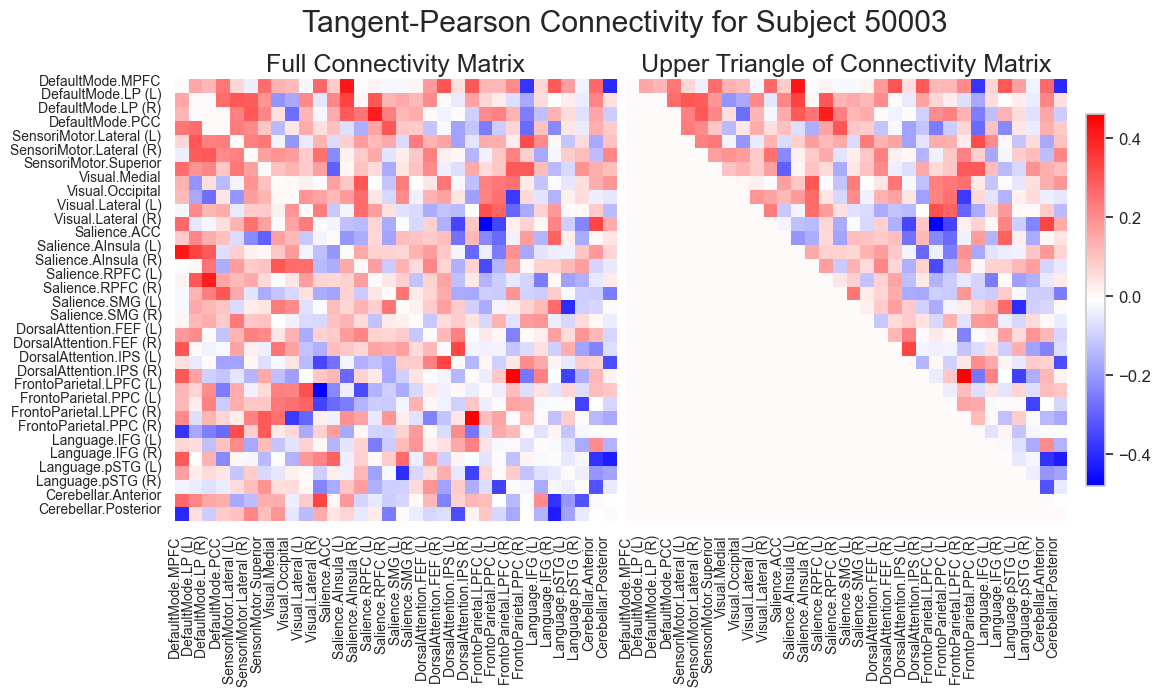

In [ ]:
from helpers.visualization import plot_connectivity_matrix

sub_idx = 0
sub_id = phenotypes.iloc[sub_idx]["SUB_ID"]

title = f"Tangent-Pearson Connectivity for Subject {sub_id}"

fig, ax = plot_connectivity_matrix(
    fc[sub_idx], rois, figsize=(12, 6), annotate=True, cmap="bwr", title=title
)
fig.show(warn=False)

The heatmap above displays the **functional connectivity (FC) matrix** for **Subject 50003**, computed using the **Tangent-Pearson** method. The matrix represents pairwise relationships between different brain regions of interest (ROIs) based on their time-series similarity.

- **Left panel – Full Connectivity Matrix**:  
  A symmetric matrix where each entry represents the strength and direction of FC between two ROIs.  
  - **Red values** indicate positive connectivity.  
  - **Blue values** indicate negative connectivity.  
  - The matrix is symmetric because the connectivity from region A to B is equal to that from B to A.

- **Right panel – Upper Triangle of the Matrix**:  
  To avoid redundancy due to symmetry, only the **upper triangular portion** of the matrix (excluding the diagonal) is shown.  
  This representation is commonly used in machine learning pipelines to **vectorize the FC matrix** for classification or regression tasks, significantly reducing the number of features from `n*n` to `n*(n-1)/2`, where `n` is the number of ROIs. However, the feature size increase will remain `O(n^2)` as the number of ROIs increases.

- **Colorbar**:  
  Indicates the range of connectivity values, with stronger connections lying at the extremes of red and blue.

This representation is widely used in neuroimaging studies for subject-level modeling, feature extraction, and biomarker discovery.

::::{exercise}
:label: find-roi-count

How many ROIs are defined in the FC matrix?

:::{hint}
:class: dropdown

- In Python, the length of arrays like lists and tuples can be
found using `len(array)`.

- The `rois` variable is an array containing the label for each
available ROI.
:::
::::

Next, we want to inspect the phenotypic information provided in **ABIDE dataset**.

In [ ]:
display(phenotypes.sample(5, random_state=cfg.RANDOM_STATE))

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
218,50302,226,50302,UM_1,UM_1_0050302,1,-9999,10.4000,2,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0
373,50501,410,50501,USM,USM_0050501,1,1,17.7057,1,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
594,50954,646,50954,NYU,NYU_0050954,1,1,14.7500,2,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0
931,51333,1003,51333,MAX_MUN,MaxMun_c_0051333,2,0,24.0000,1,R,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,1
14,50017,16,50017,PITT,Pitt_0050017,1,1,22.7000,1,R,...,NaN,maybe,skull-striping fail,maybe,ic-cerebellum_temporal_lob,fail,noise,OK,NaN,1


As we can see, there is a wide range of phenotypic information available for each subject ranging from patient descriptors such as site (`SITE_ID`), diagnostic group (`DX_GROUP`), and age at scan (`AGE_AT_SCAN`), to quality control metrics for individual scans (e.g., columns starting with `qc`).

::::{exercise}
:label: find-number-of-phenotypes

How many phenotypic variables are available in the ABIDE dataset?
::::

We also want to know how the phenotypes are distributed, we can visualize it with count and histogram plot for categorical and continuous variable respectively. Following Kunda et al. (2022), we mainly focused on the distribution of site, gender, handedness, eye status, age, and FIQ.

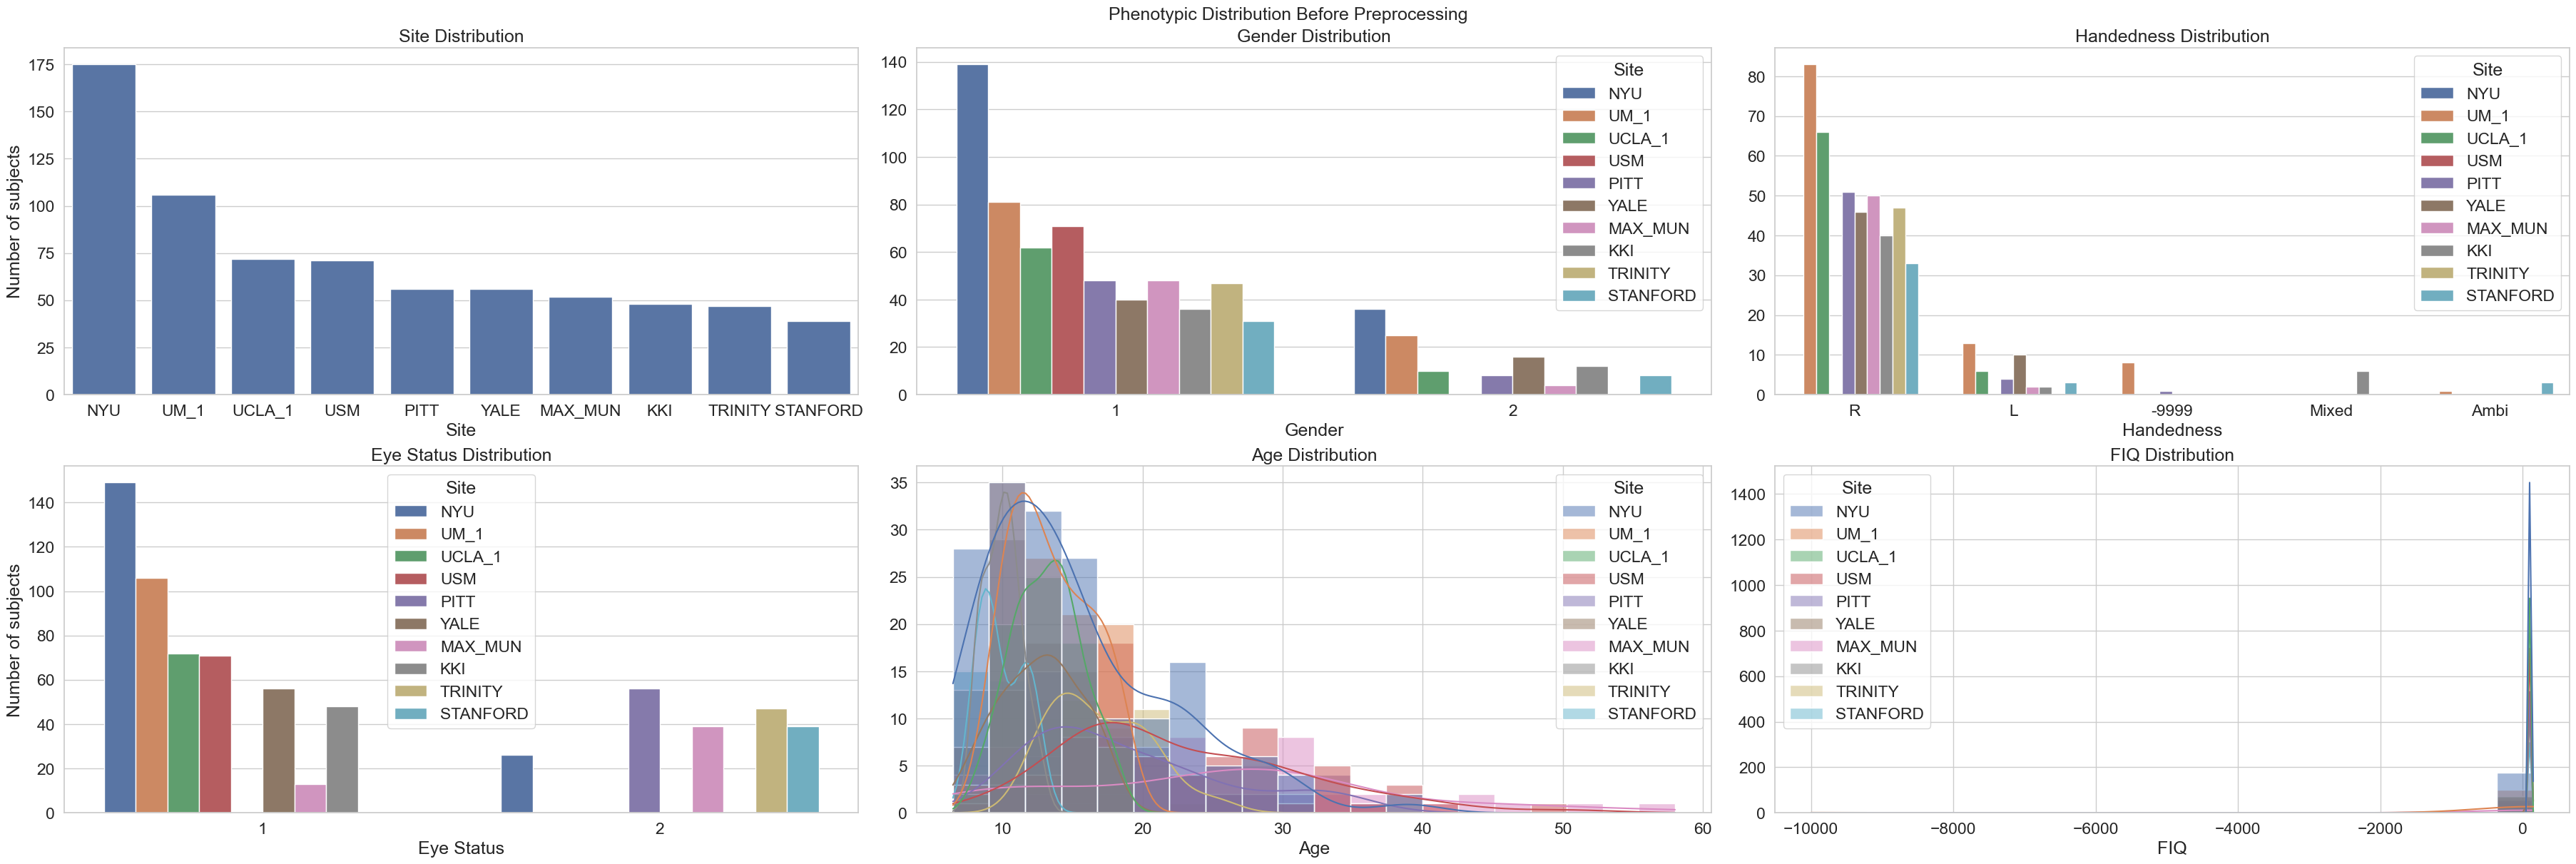

In [ ]:
from helpers.visualization import plot_phenotypic_distribution

# Prepare phenotypic values for plotting
values = [
    ("Site", phenotypes["SITE_ID"], "category"),
    ("Gender", phenotypes["SEX"], "category"),
    ("Handedness", phenotypes["HANDEDNESS_CATEGORY"], "category"),
    ("Eye Status", phenotypes["EYE_STATUS_AT_SCAN"], "category"),
    ("Age", phenotypes["AGE_AT_SCAN"], "double"),
    ("FIQ", phenotypes["FIQ"], "double"),
]

# Plot phenotypic distribution
fig, _ = plot_phenotypic_distribution(
    *values,
    title="Phenotypic Distribution Before Preprocessing",
    ncols=3,
    figsize=(36, 12),
)
fig.show(warn=False)

Several important observations can be made:

- **Site Distribution**: The majority of subjects were collected at **NYU**, followed by **UM_1** and **UCLA_1**. Other sites like **USM**, **PITT**, and **YALE** have relatively fewer samples. This imbalance in sample size could bias model performance toward larger sites if not properly addressed through **harmonization** or **site-stratified validation**.

- **Gender Distribution**: Across nearly all sites, the dataset is **male-dominated** (`1` = male, `2` = female), a known characteristic of ABIDE. The **underrepresentation of females** could limit the generalizability of sex-related findings.

- **Handedness Distribution**: Most subjects are **right-handed (`R`)**, with smaller proportions of **left-handed (`L`)**, **ambidextrous (`Ambi`)**, and **mixed**. Notably, there is a **substantial number of `-9999` entries**, indicating **missing or invalid data**. This missingness is uneven across sites, potentially introducing site-specific biases.

- **Eye Status Distribution**: Most scans were recorded with subjects' **eyes open (`1`)**, though a non-negligible number had **eyes closed (`2`)**. The distribution is generally consistent across sites, with minimal missing data.

- **Age Distribution**: The age of participants ranges from around **5 to 55 years**, with a strong skew toward younger subjects, especially between **7 and 18 years old**. This is typical of developmental neuroimaging datasets and emphasizes the need to **control for age** in modeling or analysis.

- **FIQ (Full-Scale IQ) Distribution**: The FIQ distribution is **severely distorted** by missing or placeholder values (e.g., **`-9999`**). These dominate the histogram and create an artificial spike around zero. Valid FIQ values span a wide range but are sparsely distributed. **Imputation or exclusion** of these invalid entries is essential for any analysis involving IQ.

### Data Preprocessing

Before modeling, we need to preprocess the phenotypic variables to ensure they are in a usable format. This includes handling missing values, encoding categorical variables, and optionally standardizing continuous ones.

:::{admonition} Optional
:class: tip
Learn more about the [categorical variables from phenotypic data](https://pykale.github.io/mmai-tutorials/tutorials/brain-disorder-diagnosis/extend-reading/data-config.html#categorical-variables-from-phenotypic-data) used in this tutorial.
:::


In [ ]:
from helpers.preprocess import preprocess_phenotypic_data

# A subset of the configuration can be modified here for quick playtest.
# Uncomment the following lines if you are interested in quickly
# modifying the configuration without modifying or making new `yml` files.

# cfg.PHENOTYPE.STANDARDIZE = "site"

labels, sites, phenotypes = preprocess_phenotypic_data(
    phenotypes, cfg.PHENOTYPE.STANDARDIZE
)

After preprocessing, we want to observe how the encoding, imputation, and standardization affected the phenotypes.

In [ ]:
display(phenotypes.sample(5, random_state=cfg.RANDOM_STATE))

,AGE_AT_SCAN,FIQ,SITE_ID_KKI,SITE_ID_MAX_MUN,SITE_ID_NYU,SITE_ID_PITT,SITE_ID_STANFORD,SITE_ID_TRINITY,SITE_ID_UCLA_1,SITE_ID_UM_1,SITE_ID_USM,SITE_ID_YALE,SEX_FEMALE,SEX_MALE,HANDEDNESS_CATEGORY_AMBIDEXTROUS,HANDEDNESS_CATEGORY_LEFT,HANDEDNESS_CATEGORY_RIGHT,EYE_STATUS_AT_SCAN_CLOSED,EYE_STATUS_AT_SCAN_OPEN
SUB_ID,,,,,,,,,,,,,,,,,,,
50302,-1.046379,-0.566951,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True
50501,-0.602117,-1.553855,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True
50954,-0.078069,-2.174853,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True
51333,-0.111109,-0.991772,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False
50017,0.546855,-1.911015,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,True,False


Now we can see that the number of phenotypes are now reduced, the continuous and categorical variables are now standardized and one-hot encoded respectively.

::::{exercise}
:label: find-number-of-phenotypes-after-preprocess

How many phenotypes are there once we have preprocessed the phenotypes?

:::{hint}
:class: dropdown

- In `pandas`, executing `pd.DataFrame.shape` outputs a `tuple` containing
`(num_rows, num_columns)`.

- The `phenotypes` variable is a `pd.DataFrame` type.
:::
::::

::::{exercise}
:label: understanding-one-hot-encoding

We have seen the preprocessed phenotypes and noted that the categorical
variables have been one-hot-encoded.

Given your observation, what does one-hot encoding do to the categorical variables?
::::

We also want to check how the phenotypes are distributed after we preprocess it.

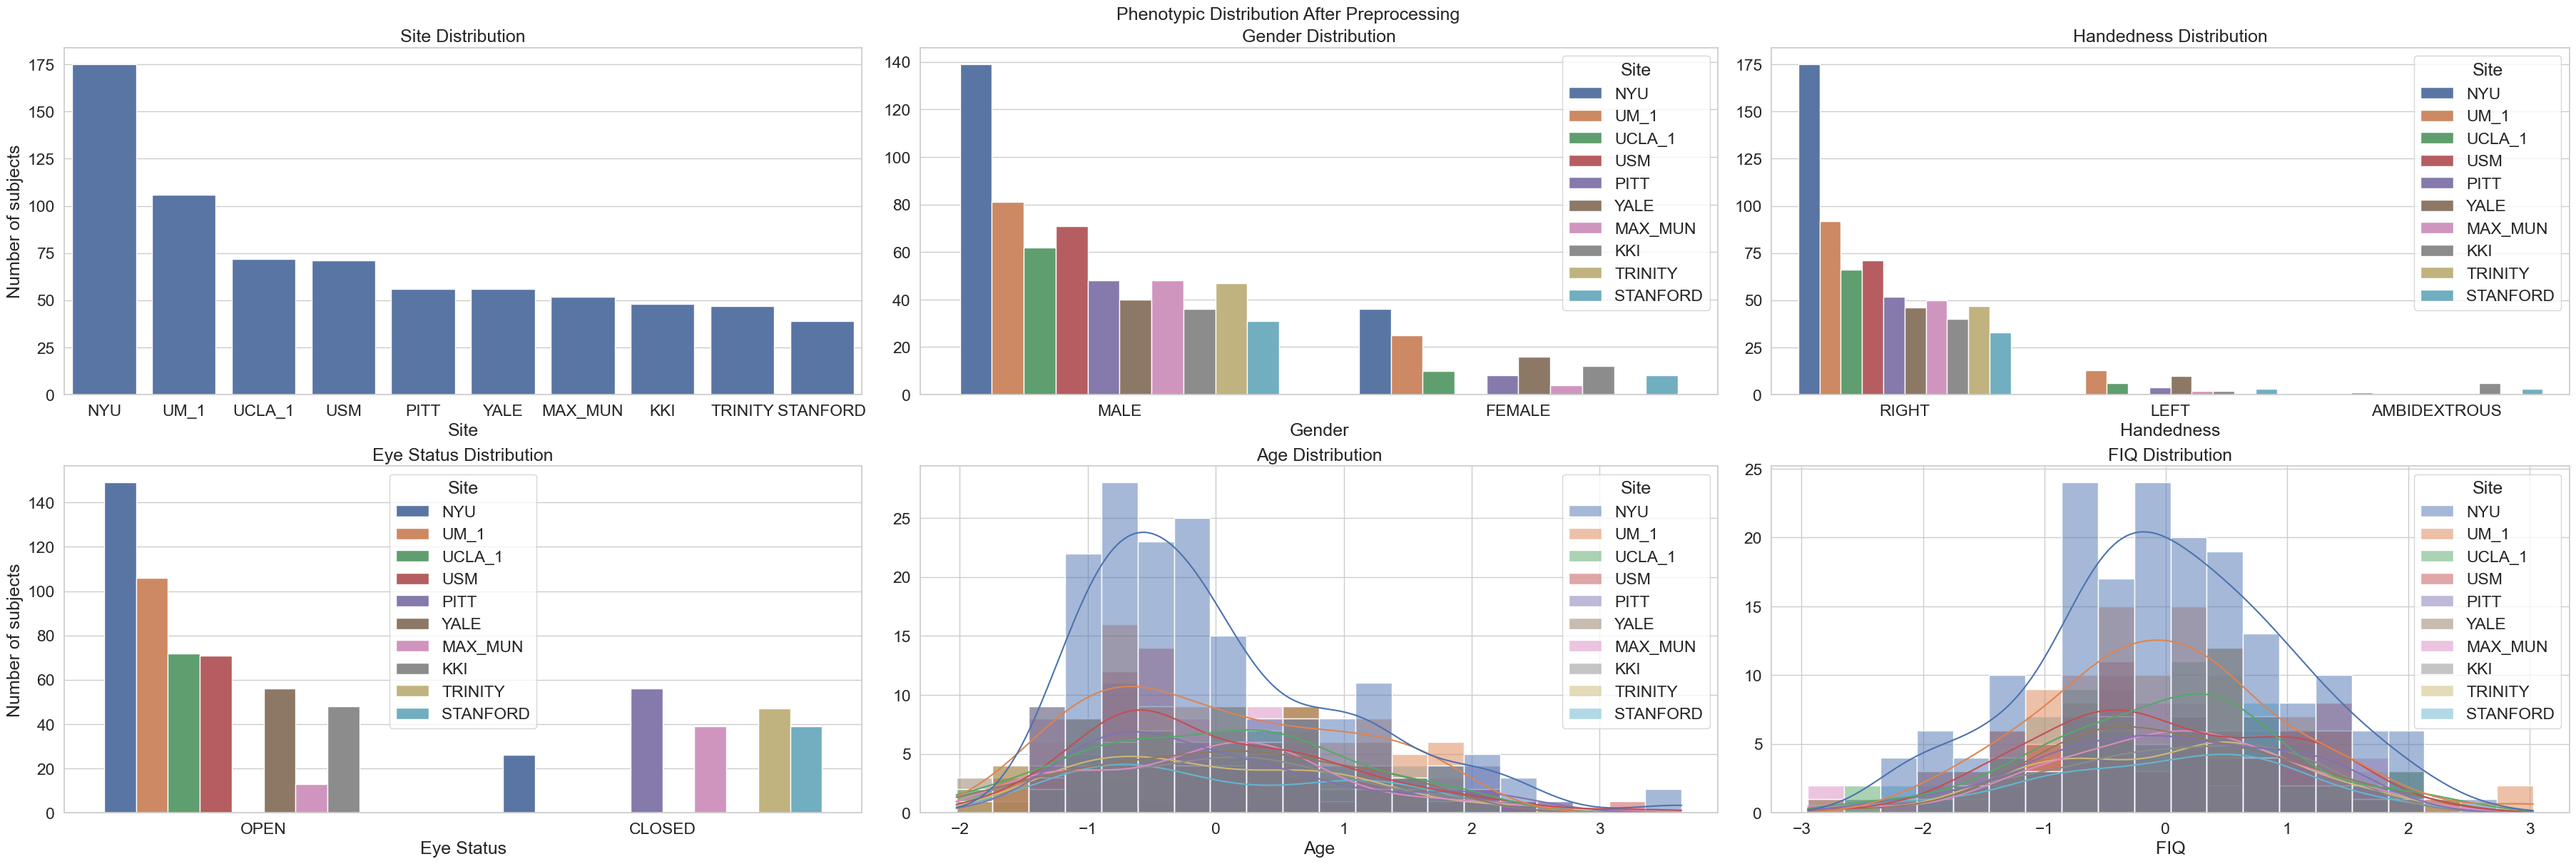

In [ ]:
from helpers.visualization import plot_phenotypic_distribution


# Mapping from column names to readable labels
MAPPING = {
    "SEX": "Gender",
    "HANDEDNESS_CATEGORY": "Handedness",
    "EYE_STATUS_AT_SCAN": "Eye Status",
    "SITE_ID": "Site",
    "AGE_AT_SCAN": "Age",
    "FIQ": "FIQ",
}

# Initialize list with site information
values = [("Site", sites, "category")]

# Iterate over relevant phenotype variables
for key, label in MAPPING.items():
    if key == "SITE_ID":
        continue

    # Direct numeric columns
    if key in ["AGE_AT_SCAN", "FIQ"]:
        values.append((label, phenotypes[key], "double"))
        continue

    # One-hot encoded categorical variables
    one_hot_cols = phenotypes.filter(like=key)
    if one_hot_cols.empty:
        continue

    # Decode one-hot encoding by extracting the max value index
    decoded = one_hot_cols.idxmax(axis=1).str.replace(f"{key}_", "")
    values.append((label, decoded, "category"))

# Plot the distributions
fig, _ = plot_phenotypic_distribution(
    *values,
    title="Phenotypic Distribution After Preprocessing",
    ncols=3,
    figsize=(36, 12),
)
fig.show(warn=False)

We can see that we can interpret the phenotypes much clearer now, as we can infer that:

- **Site Distribution**: The overall site imbalance remains, with **NYU** contributing the largest number of subjects, followed by **UM_1** and **UCLA_1**. This is expected given no missing values for the site label.

- **Gender Distribution**: The gender imbalance persists post-preprocessing, with **male subjects still forming the majority** at each site. Like site, its distribution remains the same as there are no missing values.

- **Handedness Distribution**: The preprocessing step appears to have **removed most invalid or missing values**, particularly entries like `-9999`. The dataset now primarily includes **right-handed** subjects, with a small proportion of **left-handed** and **ambidextrous** individuals. This results in a cleaner handedness distribution, thus also reducing the dimension size of one-hot encoded handedness.

- **Eye Status Distribution**: The **eye status remains consistent**, with most subjects scanned with **eyes open**. Very few entries are labeled with **eyes closed**, and no missing values are apparent, suggesting good data completeness for this variable.

- **Age Distribution**: Age values have been **normalized**, and the distribution now appears centered around zero (z-scored). The skew toward younger participants is still present, but more subtle. This normalization facilitates fair comparison across sites and removes scale bias in modeling.

- **FIQ (Full-Scale IQ) Distribution**: Similar to age, FIQ has been **standardized**, producing a roughly normal distribution across sites. The spike of invalid values (`-9999`) observed in the raw data has been eliminated, indicating effective handling of missing or outlier values during preprocessing. This cleaner distribution is more suitable for downstream statistical analysis and machine learning models.

## Step 2: Model Definition

**PyKale** provides flexible pipelines for modelling interdisciplinary problems. In our case, the primary objective is to develop a **robust yet interpretable model** capable of effectively integrating multi-site data.

We leverage the `kale.pipeline.multi_domain_adapter.AutoMIDAClassificationTrainer` (or simply `Trainer`), which encapsulates the domain adaptation method [**Maximum Independence Domain Adaptation (MIDA)**](https://ieeexplore.ieee.org/document/7815350) [4]. This trainer integrates domain adaptation with classification by allowing the user to specify any `scikit-learn`-compatible linear classifier for prediction, offering a convenient way to construct powerful and flexible pipelines.

In the following sections, we first describe the **cross-validation split** strategy used in this tutorial, followed by an explanation of the **embedding extraction** and **prediction** methods.

### Cross-Validation Split

The choice of cross-validation strategy can significantly impact how can we evaluate of a model's robustness and generalizability, especially when dealing with multi-site or grouped data.

:::{figure} images/cross-validation.png
Illustrative comparison between random k-fold and leave-one-site-out [5].
:::

The figure above compares two different cross-validation strategies which we will consider for this tutorial:

- **n-Repeated Stratified k-Fold (SKF)**:  
  This method ensures that each fold maintains the original label distribution (e.g., equal proportion of `+` and `−` classes). However, it does **not** guarantee that data from the same group (e.g., site, subject, scanner) are kept together, potentially leading to data leakage if the same group appears in both train and test splits.

- **Leave-One-Site-Out or Leave p-Groups Out (LPGO)**:
  This method preserves the **group structure** by leaving out entire groups during each iteration. It is particularly suited for evaluating generalization to unseen sites or subjects, as it avoids group leakage. However, it may result in imbalanced label distributions in each fold.

Each method serves a different purpose: stratified k-fold is ideal when label balance is critical, while leave-p-groups-out is better for assessing model robustness under domain shift or site variability. Realistically, LPGO is preferable given real data will most likely not have the same distribution as a model's training data.

::::{exercise}
:label: find-total-models-produced

Consider we evaluate a model using SKF with two repetition and five folds or LPGO with ten groups with one group left out for testing, we will need to train a total of ten models. If we evaluate a model using:
- SKF with five repetition and ten folds
- LPGO with five groups and two groups left out for testing

How many models we have to train for each cases?

:::{hint}
:class: dropdown
For LPGO, given `m` total groups and `p` left out groups, consider it as a combinatorial problem.
:::
::::

:::{admonition} Optional
:class: tip
Learn more about the [configuration arguments for cross-validation](https://pykale.github.io/mmai-tutorials/tutorials/brain-disorder-diagnosis/extend-reading/data-config.html#configuration-arguments-for-cross-validation) used in this tutorial.
:::

In [ ]:
from sklearn.model_selection import LeavePGroupsOut, RepeatedStratifiedKFold

# A subset of the configuration can be modified here for quick playtest.
# Uncomment the following lines if you are interested in quickly
# modifying the configuration without modifying or making new `yml` files.

# cfg.CROSS_VALIDATION.SPLIT = "skf"
# cfg.CROSS_VALIDATION.NUM_FOLDS = 5
# cfg.CROSS_VALIDATION.NUM_REPEATS = 2

# Define the default cross-validation strategy:
# Repeated stratified k-fold maintains class distribution across folds and supports multiple repetitions
cv = RepeatedStratifiedKFold(
    # Number of stratified folds
    n_splits=cfg.CROSS_VALIDATION.NUM_FOLDS,
    # Number of repeat rounds
    n_repeats=cfg.CROSS_VALIDATION.NUM_REPEATS,
    # Ensures reproducibility, intentionally set to the seed to have the same splits across runs
    random_state=cfg.RANDOM_STATE,
)

# Override with leave-p-proups-out if specified
# This strategy holds out `p` unique groups (e.g., sites) per fold, enabling group-level generalization
if cfg.CROSS_VALIDATION.SPLIT == "lpgo":
    # Use group-based CV for domain adaptation or site bias evaluation
    cv = LeavePGroupsOut(cfg.CROSS_VALIDATION.NUM_FOLDS)

### Embedding Extraction

**Domain adaptation** aims to reduce distributional discrepancies between datasets collected under different conditions (e.g., sites, scanners, protocols). This helps ensure that the learned representations generalize across domains.

**MIDA** was originally proposed by [Yan et al. (2017)](https://ieeexplore.ieee.org/document/7815350) [4] in *IEEE Transactions on Cybernetics* to reduce time-varying drift in sensors, using domain features such as device label and acquisition time.

Kunda et al. (2022) extended MIDA for neuroimaging studies, enabling multi-domain adaptation for **multi-site data integration**.

PyKale includes a `scikit-learn`-style implementation of MIDA in `kale.embed.factorization.MIDA`, adopting a similar interface to `KernelPCA` to ensure interoperability, extensive customization, and ease of use.

### Prediction Methods

To maintain compatibility and user-friendliness, PyKale supports **linear classifiers** from `scikit-learn`, including:

- **Logistic Regression (LR)**
- **Support Vector Machines (SVM)**
- **Ridge Classifier (Ridge)**

These models can be selected easily by passing the appropriate string identifier, streamlining experimentation with different classifiers.

Linear classifiers are particularly suitable in this context due to their **inherent interpretability**. Its coefficients can be directly inspected to understand the contribution of each feature to the prediction.

### Baseline and Proposed Model

We define several model configurations used for classification. Each model shares the same base classifier but differs in how domain adaptation is applied:

- **Baseline**: A standard model trained directly on functional connectivity features without domain adaptation.
- **Site Only**: A domain-adapted model that uses site labels as the adaptation factor to reduce site-specific bias.
- **All Phenotypes**: An extended domain-adapted model that incorporates multiple phenotypic variables (e.g., age, sex, handedness) to further reduce inter-site variability.

:::{admonition} Optional
:class: tip
Learn more about the [hyperparameter grid](https://pykale.github.io/mmai-tutorials/tutorials/brain-disorder-diagnosis/extend-reading/data-config.html#hyperparameter-grid) used in this tutorial.
:::

In [ ]:
from sklearn.base import clone
from kale.pipeline.multi_domain_adapter import AutoMIDAClassificationTrainer as Trainer

from helpers.parsing import parse_param_grid

# A subset of the configuration can be modified here for quick playtest.
# Uncomment the following lines if you are interested in quickly
# modifying the configuration without modifying or making new `yml` files.

# cfg.MODEL.CLASSIFIER = "lr"
# cfg.MODEL.PARAM_GRID = None
# cfg.MODEL.NUM_SEARCH_ITER = 100
# cfg.MODEL.NUM_SOLVER_ITER = 100

# Configuration with cv and random_state/seed included
trainer_cfg = {k.lower(): v for k, v in cfg.TRAINER.items() if k != "PARAM_GRID"}
trainer_cfg = {**trainer_cfg, "cv": cv, "random_state": cfg.RANDOM_STATE}

# Initialize dictionary for different trainers
trainers = {}

# Create a baseline trainer without domain adaptation (MIDA disabled)
param_grid = parse_param_grid(cfg.TRAINER.PARAM_GRID, "domain_adapter")
trainers["baseline"] = Trainer(use_mida=False, param_grid=param_grid, **trainer_cfg)

# Create a trainer with MIDA enabled, using site labels as domain adaptation factors
param_grid = parse_param_grid(cfg.TRAINER.PARAM_GRID)
trainers["site_only"] = Trainer(use_mida=True, **trainer_cfg)

# Clone the 'site_only' trainer to create 'all_phenotypes' trainer
# This enables reusing the same training configuration, while modifying only the input domain factors
trainers["all_phenotypes"] = clone(trainers["site_only"])

## Step 3: Model Training

The `Trainer` automatically handles model training and hyperparameter tuning based on the specified cross-validation strategy. To initiate training, simply call the `fit(...)` method, which accepts the following arguments:

- `x`: The input features used for training and tuning the model.

- `y`: The target labels corresponding to each sample.

- `groups`: Group identifiers for each sample, used specifically in group-aware cross-validation methods such as Leave-p-Groups-Out (LPGO).

- `group_labels`: Additional metadata or domain features describing each sample (e.g., phenotypes, one-hot encoded site indicators) used by the domain adaptation method.

This interface allows seamless integration of domain information and supports robust validation across multi-site datasets.

As noted earlier, we evaluate three model variants:

- For the **baseline** model, no additional `group_labels` are required, as domain adaptation is not applied.
- The **site only** and **all phenotypes** models **do require** `group_labels` to be specified in order to enable domain adaptation using site or phenotypic information.

Given that we have already preprocessed the phenotypic data and extracted site labels, we can pass the appropriate `group_labels` during training:

- Use `sites` for the **site only** model.
- Use the full `phenotypes` data (including one-hot encoded site and demographic features) for the **all phenotypes** model.

This demonstrates that the `Trainer` provides flexible control over the use of **MIDA**, allowing users to choose whether or not to incorporate domain adaptation based on the available metadata and the specific goals of their analysis.

***Estimated Runtime in Google Colab***: 18-25 minutes

In [ ]:
import pandas as pd
from tqdm import tqdm

# Define common training arguments for all models: features (X), labels (y), and group info (sites)
fit_args = {"x": fc, "y": labels, "groups": sites}

cv_results = {}
for model in (pbar := tqdm(trainers)):
    args = clone(fit_args, safe=False)
    if model == "site_only":
        args["group_labels"] = sites
    if model == "all_phenotypes":
        args["group_labels"] = phenotypes

    pbar.set_description(f"Fitting {model} model")
    trainers[model].fit(**args)
    cv_results[model] = pd.DataFrame(trainers[model].cv_results_)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting all_phenotypes model: 100%|██████████| 3/3 [01:01<00:00, 20.52s/it]


Once the models are simultaneously trained and tuned, the cross-validation results are stored in the `cv_results_` attribute. These results are automatically sorted according to the metric specified in the `refit` argument.

The `cv_results_` object contains comprehensive information, including:
- The hyperparameter configurations explored during tuning.
- Performance scores for each split.
- Aggregated statistics such as the mean and standard deviation across folds.

This allows for detailed inspection and comparison of model performance across different hyperparameter settings.

If we are only interested in a single evaluation metric, we can use the `best_score_` attribute to retrieve the best average performance across all splits based on that metric.

To facilitate comparison across models, we aggregate each model’s `cv_results_` into a `dict` of `pd.DataFrame` objects. These can then be compiled into a summary table that highlights the best-tuned performance for each of the three evaluated models.

::::{exercise}
:label: find-the-aggregate-in-cv-results
Can you mention what are the available aggregates for each metrics found in `cv_results_`?

:::{hint}
:class: dropdown
You can inspect `cv_results_` or `cv_results[model]` just like `phenotypes`.
:::
::::

## Step 4: Evaluation

After training and tuning the models, we evaluate the performance of the three model configurations using **accuracy** as the primary metric for comparison.

We compile the top-performing scores from cross-validation for each model, allowing us to assess the effectiveness of different domain adaptation strategies. By comparing models with and without domain adaptation, we can examine the impact of incorporating **site** and **phenotypic** information on multi-site autism classification performance.

This can be done using the `compile_results` function, which summarizes cross-validation outputs into a clean and comparable format. The function accepts the following:

- `cv_results`: A dictionary that maps model names (e.g., `"Baseline"`, `"Site Only"`, `"All Phenotypes"`) to their cross-validation results. These can either be `pandas.DataFrame` objects or nested dictionaries with performance scores.
- `sort_by`: The metric used to select the best-performing configuration for each model. Supported metrics include `"accuracy"`, `"precision"`, `"recall"`, `"f1"`, `"roc_auc"`, and `"matthews_corrcoef"`.

It returns a `pd.DataFrame` where each row corresponds to a model, and each column shows the formatted score (e.g., `mean ± std`) for the selected metric.

This analysis highlights which configurations generalize best across heterogeneous imaging sites.

In addition, we report performance from an experiment using **2-repeated stratified 5-fold cross-validation**, which can be run by loading the configuration file at `experiments/skf/base.yml`. As expected, the performance differences are less pronounced in this setting. This is likely because blending data from different sites maintains label distribution but does **not** reflect a realistic evaluation of generalization under domain shift, a scenario encountered when deploying models to unseen sites.

| Model              | Accuracy           | AUROC             |
|:------------------|:------------------:|:-----------------:|
| **Baseline**       | 0.6711 ± 0.0330    | 0.7295 ± 0.0238   |
| **Site Only**      | 0.6877 ± 0.0357    | 0.7372 ± 0.0228   |
| **All Phenotypes** | 0.6849 ± 0.0314    | 0.7396 ± 0.0215   |

The key question now is: **Does domain adaptation actually improve predictive performance under a leave-one-group-out setting, where generalization to unseen sites is critical?**

In [ ]:
from helpers.parsing import compile_results

# Compile the cross-validation results into a summary table,
# sorting by the model with the highest test accuracy across CV folds
compiled_results = compile_results(cv_results, "accuracy")

# Display the compiled results DataFrame (models as rows, metrics as formatted strings)
display(compiled_results)

,Accuracy,AUROC
Model,,
Baseline,0.6678 ± 0.0982,0.7152 ± 0.0883
Site Only,0.6960 ± 0.0884,0.7233 ± 0.0925
All Phenotypes,0.6902 ± 0.0948,0.7241 ± 0.0884


Turns out, domain adaptation indeed helps when evaluated under the **leave-one-group-out** setting.

We observe a consistent performance improvement when incorporating site and phenotypic information:

- The **Site Only** model achieves the highest accuracy, indicating that accounting for site differences is beneficial for generalization.
- The **All Phenotypes** model also outperforms the **Baseline**, suggesting that additional phenotypic features contribute useful domain information, although the performance difference over site alone is marginal given the accuracy and AUROC.
- The **Baseline** model, which does not use domain adaptation, performs worst, highlighting the challenge of multi-site variability when no adaptation is applied.

These results demonstrate the effectiveness of domain adaptation in improving model generalization across imaging sites, especially in scenarios where each site may exhibit different data distributions.

## Step 5: Interpretation

We interpret the trained models by analyzing the learned weights associated with functional connectivity features. Specifically, we extract the top-weighted ROI pairs that contribute most to the classification decision.

These weights are visualized using a **connectome plot**, which helps reveal the brain region interactions that are most informative for distinguishing individuals with autism from neurotypical controls. This enhances the **interpretability** of the model and may offer insights into **neurobiological patterns** relevant to autism.

To support this, **PyKale** extends `nilearn`'s `plot_connectome` through the utility `kale.interpret.visualize.visualize_connectome`. This enhanced version improves interpretability by:
- Adding annotations for each ROI.
- Visualizing only the top-weighted connections between regions, making the plot more focused and informative.

This visualization aids both in model transparency and in deriving neuroscientific interpretations from machine learning outputs.

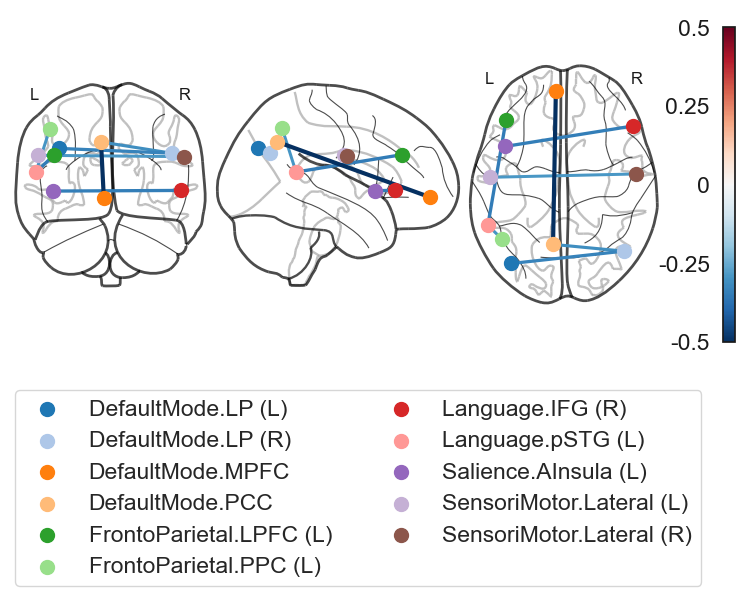

In [ ]:
import numpy as np
from kale.interpret.visualize import visualize_connectome

# Fetch model with best performance
best_model = max(cv_results, key=lambda m: trainers[m].best_score_)
# Fetch coefficients to visualize feature importance
coef = trainers[best_model].coef_.ravel()
# check if coef != features, assumes augmented features with phenotypes/sites
if coef.shape[0] != fc.shape[1]:
    coef, _ = np.split(coef, [fc.shape[1]])

# Visualize the coefficients as a connectome plot
proj = visualize_connectome(
    coef,
    rois,
    coords,
    1.5 / 100,  # Take top 1.5% of connections
    legend_params={
        "bbox_to_anchor": (3.5, -0.4),  # Align legend outside the plot
        "ncol": 2,
    },
)

# Display the resulting connectome plot
display(proj)

The figure illustrates the **most discriminative ROI-to-ROI functional connections** that differentiate **Autism Spectrum Disorder (ASD)** participants from **Controls**, based on group-level functional connectivity analysis.

- **Blue edges** indicate **stronger functional connectivity in Control** participants.
- **Red edges** (not present in this figure) would indicate **stronger connectivity in ASD**.
- The **color saturation** and **thickness of the edges** represent the **magnitude of discriminative contribution** of each connection.

---

**Key Observations**

- **Default Mode Network (DMN)**  
  - Includes: *DefaultMode.MPFC*, *DefaultMode.PCC*, *DefaultMode.LP (L/R)*  
  - Several intra-DMN and interhemispheric connections appear weaker in ASD, aligning with known disruptions in **self-referential thinking** and **social cognition**.

- **Fronto-Parietal Network**  
  - Includes: *FrontoParietal.LPFC (L)*, *FrontoParietal.PPC (L)*  
  - Weaker connectivity in this network may indicate impaired **executive function** and **cognitive control**, both commonly reported in ASD.

- **Language Network**  
  - Includes: *Language.IFG (R)*, *Language.pSTG (L)*  
  - Reduced connections involving language-related areas suggest **communication challenges** in ASD.

- **Salience and Sensorimotor Networks**  
  - Includes: *Salience.AInsula (L)*, *SensoriMotor.Lateral (L/R)*  
  - Altered connectivity in these regions may reflect atypical **sensory integration** and **interoception**, frequently observed in autistic individuals.

---

**Interpretation Considerations**

While these patterns provide evidence for disrupted **large-scale network integration** in ASD, caution is warranted:

- Regions such as **sensorimotor cortex** are known to be **susceptible to head motion** and **site-related variability**.
- The presence of domain adaptation and harmonization in the modeling pipeline reduces, but does not fully eliminate these confounds.
- Therefore, while findings involving **DMN** and **language networks** are likely robust, sensorimotor findings should be interpreted with care.

---

**Summary**

This figure underscores a consistent pattern of **reduced functional connectivity** across the **Default Mode**, **Language**, **Fronto-Parietal**, and **Sensorimotor** networks in ASD. These disruptions support the theory of altered **network-level integration** in autism and bolster the potential of **connectivity-based biomarkers** for diagnostic classification.

## References

[1] Lu, H., Liu, X., Zhou, S., Turner, R., Bai, P., Koot, R. E., ... & Xu, H. (2022, October). PyKale: Knowledge-aware machine learning from multiple sources in Python. In _Proceedings of the 31st ACM International Conference on Information & Knowledge Management_ (pp. 4274-4278).

[2] Craddock, C., Benhajali, Y., Chu, C., Chouinard, F., Evans, A., Jakab, A., ... & Bellec, P. (2013). The neuro bureau preprocessing initiative: open sharing of preprocessed neuroimaging data and derivatives. _Frontiers in Neuroinformatics_, 7(27), 5.

[3] Kunda, M., Zhou, S., Gong, G., & Lu, H. (2022). Improving multi-site autism classification via site-dependence minimization and second-order functional connectivity. _IEEE Transactions on Medical Imaging_, 42(1), 55-65.

[4] Yan, K., Kou, L., & Zhang, D. (2017). Learning domain-invariant subspace using domain features and independence maximization. _IEEE transactions on cybernetics_, 48(1), 288-299.

[5] Abraham, A., Milham, M. P., Di Martino, A., Craddock, R. C., Samaras, D., Thirion, B., & Varoquaux, G. (2017). Deriving reproducible biomarkers from multi-site resting-state data: An Autism-based example. _NeuroImage_, 147, 736-745.